In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import time
import h5py
import joblib
from sklearn.decomposition import PCA

# Train PCA

Fit a PCA model on a random sample of 100k (should capture the distribution of the variation pretty well)

#### Notes:

* Scale pixel to [0,1] (not strictly necessary)
* Don't use PCA whitening
* Use 1000 components

In [2]:
def train_pca(filepath, n_components, N=100000):
    f = h5py.File(filepath, 'r')
    X_dataset, y_dataset = list(f.items())
    X_dataset, y_dataset = np.moveaxis(X_dataset[1][:], 1, 3), y_dataset[1][:]
    
    np.random.seed(0)
    index = np.random.choice(len(X_dataset), N, replace=False)
    X_dataset, y_dataset = X_dataset[index], y_dataset[index]
    
    print('Sample Size: %d' % N)
    print('Data Types X=%s, y=%s' % (X_dataset.dtype, y_dataset.dtype))
    print('Shape X=%s, y=%s' % (X_dataset.shape, y_dataset.shape))
    
    pca = PCA(n_components=n_components, whiten=False)
    
    start = time.time()
   
    # Reshape to 1-D array
    shape = X_dataset.shape
    X_reshape = X_dataset.reshape((shape[0], -1)) / 255.
    X_reshape.shape
   
    pca.fit(X_reshape)
    X_pca = pca.transform(X_reshape)
    
    end = time.time()
    elapsed = end - start
    print('Fit time elapsed: {}'.format(elapsed))
    
    return pca
   
n_components = 1000
filepath = '../../data/svhn/svhn_format_2.hdf5'
pca = train_pca(filepath, n_components=n_components)

Sample Size: 100000
Data Types X=uint8, y=uint8
Shape X=(100000, 32, 32, 3), y=(100000, 1)
Fit time elapsed: 116.24839305877686


In [3]:
model_path = 'saved_models/pca_%d.pkl' % n_components
print('Dumping pca (%d) model to: %s' % (n_components, model_path)) 
joblib.dump(pca, model_path)

Dumping pca (1000) model to: saved_models/pca_1000.pkl


['saved_models/pca_1000.pkl']

# Test PCA

Display original and reconstructed images to ensure that PCA worked correctly.

In [4]:
# Test PCA model
pca = joblib.load(model_path)
pca

PCA(copy=True, iterated_power='auto', n_components=1000, random_state=None,
  svd_solver='auto', tol=0.0, whiten=False)

In [5]:
def display_grid(dataset, digit_size=32, grid_size=5, seed=None):
    # Display some digits to figure out what's going on
    figure = np.zeros((digit_size * grid_size, digit_size * grid_size, 3))
   
    if seed is not None:
        np.random.seed(seed)
    for i in range(grid_size):
        for j in range(grid_size):
            digit = dataset[np.random.randint(len(dataset))]
            d_x, d_y = i * digit_size, j * digit_size
            figure[d_x:d_x + digit_size, d_y:d_y + digit_size, :] = digit.astype(int)
            
    plt.figure(figsize=(5, 5))
    plt.imshow(figure)
    plt.show()

Originals


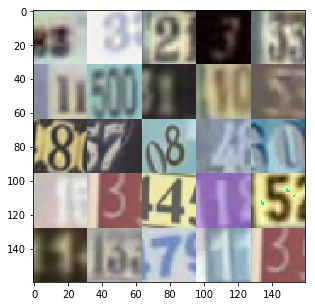

Reconstructed PCA


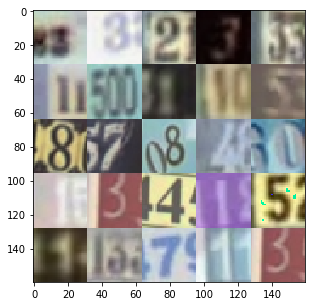

In [6]:
f = h5py.File(filepath, 'r')
sample_size = 1000
X_dataset, y_dataset = list(f.items())
X_dataset, y_dataset = np.moveaxis(X_dataset[1][:], 1, 3), y_dataset[1][:]

print("Originals")
index = np.random.choice(len(X_dataset), sample_size, replace=False)
X_dataset, y_dataset = X_dataset[index], y_dataset[index]
display_grid(X_dataset, seed=0)

print("Reconstructed PCA")
X_reshape = X_dataset.reshape((X_dataset.shape[0], -1)) / 255.
X_pca = pca.transform(X_reshape)
X_recon = pca.inverse_transform(X_pca)
X_recon_reshape = X_recon.reshape(X_dataset.shape) * 255.
display_grid(X_recon_reshape, seed=0)

We see a bit of corruption but overall not too bad.